### Introduction to Data Science
## Homework 3: Due 5pm to My Mailbox (2nd Floor, 19 W 4th St) Wednesday April 19th

Student Name: Roshan Kumar

Student Netid: rk3110
***

In this assignment we will be looking at data generated by particle physicists to test whether machine learning can help classify whether certain particle decay experiments identify the presence of a Higgs Boson. One does not need to know anything about particle physics to do well here, but if you are curious, full feature and data descriptions can be found here:

- https://www.kaggle.com/c/higgs-boson/data
- http://higgsml.lal.in2p3.fr/files/2014/04/documentation_v1.8.pdf

The goal of this assignment is to learn to use cross-validation for model selection. We’ll also use learning curve analysis to understand how well different algorithms make use of limited data. For more documentation on cross-validation with Python, you can consult the following:

- http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation


### Part 1: Data preparation
Create a data preparation and cleaning function that does the following:
- Has a single input that is a file name string
- Reads data (the data is comma separated, has a row header and the first column `EventID` is the index) into a pandas `dataframe`
- Cleans the data
  - Convert the feature `Label` to numeric (choose the minority class to be equal to 1)
    - Create a feature `Y` with numeric label
    - Drop the feature `Label`
  - If a feature has missing values (i.e., `-999`): 
    - Create a dummy variable for the missing value
      - Call the variable `orig_var_name` + `_mv` where `orig_var_name` is the name of the actual var with a missing value
      - Give this new variable a 1 if the original variable is missing
    - Replace the missing value with the average of the feature (make sure to compute the mean on records where the value isn't missing). You may find pandas' `.replace()` function useful.
- After the above is done, rescales the data so that each feature has zero mean and unit variance (hint: look up sklearn.preprocessing)
- Returns the cleaned and rescaled dataset

Hint: as a guide, this function can easily be done in less than 15 lines.

In [56]:
import pandas as pd
import numpy as np
from sklearn import preprocessing # Used here to rescale the data so that each feature has zero mean and unit variance
# It is a standard practice in ml. http://scikit-learn.org/stable/modules/preprocessing.html


def cleanBosonData(infile_name):
    # Code here
    #1. Read the data into a data frame
    data_clean = pd.read_csv(infile_name)
    #2. clean the dataframe
        # 2.1 create a numeric feature Y
    # s is the minority class
    #data_clean['Y'] = data_clean['Label']
    # series.value_counts gives count of distinct values the column(series) takes as a series with
    # column values as index and count as the values. 
    # series.sort_values sorts the series based on values.
    # series.index[0] returns index of first entry in the series
    minority_class = data_clean['Label'].value_counts().sort_values().index[0]
    # df.apply applies the function passed to each entry along the specified axis. Here it 
    # applies the lambda function along each of its rows
    data_clean['Y'] = data_clean.apply(lambda x: 1 if x['Label']==minority_class else 0,axis=1)
    #data_clean['Y'] = data_clean['Label'].replace("s", 1).replace('b',0)
    # 2.2 drop feature label
    data_clean=data_clean.drop('Label', 1)
    original_cols = data_clean.columns
    # Deal with missing values 
    # http://stackoverflow.com/questions/28180894/calculate-dataframe-mean-by-skipping-certain-values-in-python-pandas
    features_missing_values = [column_name for column_name in data_clean.columns.values if -999 in data_clean[column_name].unique()]
    for feature in features_missing_values:
        new_column = feature+"_mv"
        data_clean[new_column] = data_clean.apply(lambda x: 1 if -999 == x[feature] else 0,axis=1)
        # Compute mean excluding certain values
        #mean = data_clean[feature].replace(-999, np.nan).mean()
        #data_clean[feature] = data_clean.apply(lambda x: mean if x[feature]==-999 else x[feature],axis=1 )
        data_clean.loc[data_clean[feature]==-999, feature]=data_clean[feature].replace(-999, np.nan).mean()
    #print features_missing_values
    # rescale the data and store in variable named data_clean
    scaler = preprocessing.StandardScaler()
    standardized_data = pd.DataFrame(scaler.fit_transform(data_clean), columns= data_clean.columns)
    standardized_data['Y'] = data_clean['Y']
    #for feature in features_missing_values: 
    #    new_col = feature+"_mv"
    #    standardized_data[new_col] = data_clean[new_col]
    #return data_clean
    return standardized_data
data = cleanBosonData("C://Users//kumar//OneDrive//Documents//GitHub//DataScienceCourse//ipython//hw//hw_3//data//boson_training_cut_2000.csv")


### Part 2: Basic evaluations
In this part you will build an out-of-the box logistic regression (LR) model and support vector machine (SVM). You will then plot ROC for the LR and SVM model.

1\. Clean the two data files included in this assignment (`data/boson_training_cut_2000.csv` and `data/boson_testing_cut.csv`) and use them as training and testing data sets.

In [57]:
data_train = cleanBosonData("data/boson_training_cut_2000.csv")
data_test = cleanBosonData("data/boson_testing_cut.csv")

2\. On the training set, build the following models:

- A logistic regression using sklearn's `linear_model.LogisticRegression()`. For this model, use `C=1e30`.
- An SVM using sklearn's `svm.svc()`. For this model, specify that `kernel="linear"`.

For each model above, plot the ROC curve of both models on the same plot. Make sure to use the test set for computing and plotting. In the legend, also print out the Area Under the ROC (AUC) for reference.

In [66]:
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics

%matplotlib inline
features = list(set(data_train.columns.values) - set('Y'))
X_train = data_train[features]
y_train = data_train['Y']
X_test = data_test[features]
y_test = data_test['Y']

# Code here
# Logistic classifier
logistic_clf = LogisticRegression(C=1e30)
logistic_clf.fit(X_train, y_train)

# SVM classifier
svc = SVC(kernel='linear',probability=True)
svc.fit(X_train, y_train)

logistic_score = logistic_clf.predict_proba(X_test)
svc_score = svc.predict_proba(X_test)
#print logistic_score
print svc_score

[[ 0.83593031  0.16406969]
 [ 0.73756332  0.26243668]
 [ 0.6824192   0.3175808 ]
 ..., 
 [ 0.76761672  0.23238328]
 [ 0.65672549  0.34327451]
 [ 0.82619918  0.17380082]]


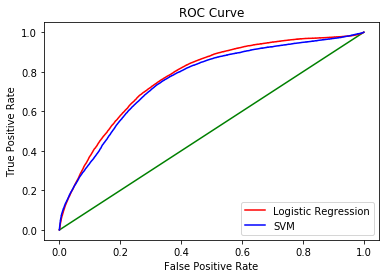

In [63]:
# ROC for both models
fpr, tpr, thresholds = metrics.roc_curve(y_test, logistic_score[:,1])
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, svc_score[:,1])

# plot these
c = (np.random.rand(), np.random.rand(), np.random.rand())
plt.plot([0, 1], [0, 1], 'g')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.plot(fpr, tpr, color='r', label= 'Logistic Regression')
plt.plot(fpr1, tpr1, color='b', label = 'SVM')
plt.legend(loc ='lower right')
plt.show()

3\. Which of the two models is generally better at ranking the test set? Are there any classification thresholds where the model identified above as "better" would underperform the other in a classification metric (such as TPR)?

Clearly, Logistic regression perform better than SVM. No there are no threshold according to the plot above where SVM performs better than logistic regresssion

### Part 3: Model selection with cross-validation
We think we might be able to improve the performance of the SVM if we perform a grid search on the hyper-parameter $C$.  Because we only have 1000 instances, we will have to use cross-validation to find the optimal $C$.

1\. Write a cross-validation function that does the following:
- Takes as inputs a dataset, a label name, # of splits/folds (`k`), a sequence of values for $C$ (`cs`)
- Performs two loops
  - Outer Loop: `for each f in range(k)`:
    - Splits the data into `data_train` & `data_validate` according to cross-validation logic
  - Inner Loop: `for each c in cs`:
    - Trains an SVM on training split with `C=c, kernel="linear"`
    - Computes AUC_c_k on validation data
    - Stores AUC_c_k in a  dictionary of values
- Returns a dictionary, where each key-value pair is: `c:[auc-c1,auc-c2,..auc-ck]`

In [59]:
from sklearn.cross_validation import *
# Code here
def xValSVM(dataset, label_name, k, cs):
    '''
    Get optimal C for SVM using k-fold cross-validation
    '''
    cv = KFold(n = dataset.shape[0], n_folds = k)
    aucs = dict()

    #outer loop
    for train_idx, test_idx in cv:
        train_k = dataset.iloc[train_idx]
        validation_k = dataset.iloc[test_idx]
        # inner loop
        for c in cs:
            svm_k = SVC(kernel = 'linear', C = c)
            svm_k.fit(train_k.drop(label_name, 1), train_k[label_name])
            score = metrics.roc_auc_score(validation_k[label_name], svm_k.decision_function(validation_k.drop(label_name,1)))
            #append score to the aucs dict
            if (aucs.has_key(c)): aucs[c].append(score)
            else: aucs[c] = [score]    
    return aucs

2\. Using the function written above, do the following:
- Generate a sequence of 10 $C$ values in the interval `[10^(-8), ..., 10^1]` (i.e., do all powers of 10 from -8 to 1).
2.	Call aucs = xValSVM(train, ‘Y’, 10, cs)
3.	For each c in cs, get mean(AUC) and StdErr(AUC) 
4.	Compute the value for max(meanAUC-StdErr(AUC)) across all values of c.
5.	Generate a plot with the following:
a.	Log10(c) on the x-axis
b.	1 series with mean(AUC) for each c
c.	1 series with mean(AUC)-stderr(AUC) for each c (use ‘k+’ as color pattern)
d.	1 series with mean(AUC)+stderr(AUC) for each c (use ‘k--‘ as color pattern)
e.	a reference line for max(AUC-StdErr(AUC)) (use ‘r’ as color pattern)

Then answer the question: Did the model parameters selected beat the out-of-the-box model for SVM? 

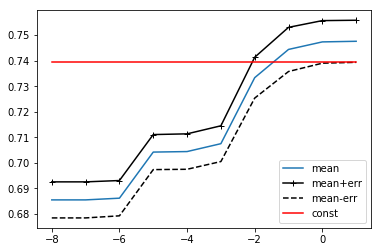

In [62]:
# trying out different values of C
#Code here
import math
xval_dict = {'c':[], 'mean':[], 'sd':[]}
c_values = [10**i for i in range(-8,2) ]
# perform cross-validation and get auc score for different c-values
aucs = xValSVM(data_train, 'Y', 10, c_values)

for c in c_values:
    xval_dict['c'].append(c)
    xval_dict['mean'].append(np.array(aucs[c]).mean())
    xval_dict['sd'].append(np.sqrt(np.array(aucs[c]).var()/10))

means = np.array(xval_dict['mean'])
c_values = np.array(xval_dict['c'])
stderr = np.array(xval_dict['sd'])

low = (means-stderr).max()
func = lambda x: math.log(x,10)
plt.plot(list(map(func, xval_dict['c'])), means, label="mean")
plt.plot(list(map(func, xval_dict['c'])), means+stderr, 'k+-', label="mean+err")
plt.plot(list(map(func, xval_dict['c'])), means-stderr, 'k--', label="mean-err")
plt.plot(list(map(func, xval_dict['c'])), low*np.ones(len(means)), 'r', label='const')
plt.legend(loc="lower right")


answer here:No as is evident from the plot; It does not improve the performance with the list of values provied in the question

3\. Which of the two algorithms are more suitable for smaller sample sizes, given the set of features? If it costs twice the investment to run enough experiments to double the data, do you think it is a worthy investment?


answer here: Logistic regression in general perform better for small sample sizes. The perfomance beomes constant after a point of time and doubling the data will not increase the performance substantially. So doubling the data might not give very high returns

4\. Is there a reason why cross-validation might be biased? If so, in what direction is it biased? (Hint: refer to ESL figure 7.8)?



answer here: Yes cross-validation is biased in the negative direction due to smaller sample size

In [ ]:
# Submission Generation

def create_submissions(predictions, threshold, filename):
    # create a dataframe
    output = pd.DataFrame({'EventId':predictions.index, 'Score':prdictions.})
    #write the dataframe to csv file
    output['Class'] = output['Score'].map(lambda x: 's' if x>threshold else 'b')
    output = output.sort('Score', ascending=False)
    output = output.reset_index(drop=True)
    output['RankOrder'] = output.index
    output['RankOrder'] = output['RankOrder'].map(lambda x: x+1)

    output[['EventId', 'RankOrder', 'Class']].to_csv(filename, index=False)
create_submissions()